<a href="https://colab.research.google.com/github/Msaleemakhtar/Langgraph/blob/main/Module_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Streaming Intreption**

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk

In [ ]:
import os
import getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


In [ ]:
from langchain_google_genai import  ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                 temperature=0.7, top_p=0.85)



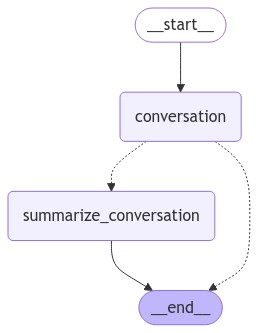

In [ ]:
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
#we use RunnableConfig to enable token-wise streaming.
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from pprint import pprint
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Lance! Nice to meet you. What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-efe4250b-92a5-4d9b-8d07-bd36f7556def-0', usage_metadata={'input_tokens': 7, 'output_tokens': 17, 'total_tokens': 24})}}


In [ ]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! It's nice to meet you.  What can I do for you today?


In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm saleem")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm saleem
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm saleem
================================== Ai Message ==================================

Hi Saleem! It's nice to meet you. What can I do for you today?
---------------------------------------------------------------------------


In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversati

In [ ]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='##', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': []}, id='run-28d6ecfe-b933-4dc8-9a17-f2872683a32f', usage_metadata={'input_tokens': 11, 'output_tokens': 1, 'total_tokens': 12})}
{'chunk': AIMessageChunk(content=' The San Francisco 49ers: A Legacy of Excellence\n\nThe San Francisco 49', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-28d6ecfe-b933-4dc8-9a17-f2872683a32f', usage_metadata={'input_tokens': 11, 'output_tokens': 20, 'total_tokens': 31})}
{'chunk': AIMessageChunk(content='ers are one of the m

In [ ]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
  # Get chat model tokens from a particular node
  if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
    data = event["data"]
    print(data["chunk"].content, end="|")

## The| San Francisco 49ers: A Legacy of Excellence

The San Francisco 49|ers are one of the most storied franchises in NFL history, boasting a rich| tradition of success and a passionate fanbase. Here's a glimpse into their story:

**Early Days:**

* Founded in 1946 as the **|"Golden Gate 49ers"** in San Francisco.
* Moved to **San Francisco's Kezar Stadium** in 1946,| later to **Candlestick Park** in 1971.
* Early years were marked by inconsistency, but a strong fan base emerged.

**The Bill Walsh Era (1979-1988):**

|* **Bill Walsh** became head coach in 1979, revolutionizing the game with his innovative **"West Coast Offense."**
* **Five Super Bowl appearances (XVI, XIX, XXIII, XXIV, XXIX)**,| winning **four Super Bowl championships** (XVI, XIX, XXIII, XXIX) during this period.
* **Joe Montana** emerged as a legendary quarterback, leading the 49ers to their dynasty.
* **Other key players:** Jerry Rice, Ronnie Lott, Steve Young, Dwight Clark, and Charles Haley.

|**The Steve Young E

# **Breakpoints**

In [ ]:
from langchain_google_genai import  ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                 temperature=0.7, top_p=0.85)


In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

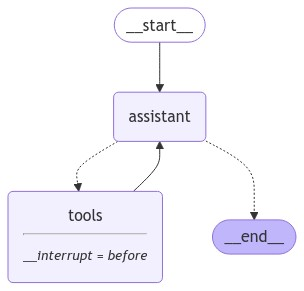

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'f

In [ ]:
state = graph.get_state(thread)
state.next

('tools',)

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (a5b2c5e8-7d9a-45ae-af8f-c77da653985b)
 Call ID: a5b2c5e8-7d9a-45ae-af8f-c77da653985b
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Mu

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'f

# **Editing graph state**

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

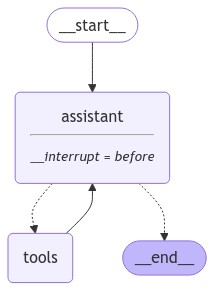

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:

state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='eb7579dc-74e7-4684-b119-8e92d72b1b4e')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef85b92-fcec-6e81-8000-6c026ce4a25a'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-08T21:06:28.930075+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef85b92-fce8-67a1-bfff-952c37fa9002'}}, tasks=(PregelTask(id='4e25b962-319e-a21d-c621-cdea20e19af3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

In [ ]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef85b97-002f-60e0-8001-c5f5f21a17bc'}}

In [ ]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {

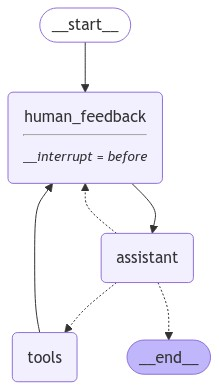

In [ ]:

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
Tell me how you want to update the state:  Multiply 6 and 3
================================ Human Message =================================

 Multiply 6 and 3
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        

In [ ]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

18
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, '

# **Time travel**

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divides a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Create a list of tools (functions)
tools = [add, multiply, divide]

# Bind tools to the LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7, top_p=0.85)
llm_with_tools = llm.bind_tools(tools)


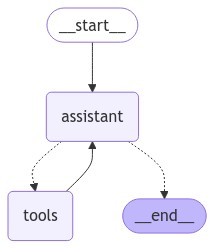

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Adds a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'f

In [ ]:
#Browsing History
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e5b1ae24-0907-41f0-99ca-8f4532f1e8c8'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b6faf78f-edb2-4aee-b87e-7a2d5a742833-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '1f2d150b-02b8-42df-baed-46d0b5b5e76e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'o

In [ ]:
all_states = [s for s in graph.get_state_history(thread)]

In [ ]:
len(all_states)

5

In [ ]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e5b1ae24-0907-41f0-99ca-8f4532f1e8c8'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b6faf78f-edb2-4aee-b87e-7a2d5a742833-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '1f2d150b-02b8-42df-baed-46d0b5b5e76e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'o

In [ ]:
all_states[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef867d8-3127-64be-bfff-0449bd74d1a4'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={})}}, 'step': -1, 'parents': {}}, created_at='2024-10-09T20:31:49.983335+00:00', parent_config=None, tasks=(PregelTask(id='13729218-5395-548d-5c4b-ff63468eae57', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None),))